In [1]:
%load_ext autoreload
%autoreload 2

import pprint
import yaml

import numpy as np
import matplotlib.pyplot as plt

import torch
from src.masks.multiblock import MaskCollator as MBMaskCollator

from src.datasets.mimic import make_mimic

from src.transforms import make_transforms


In [2]:
with open("configs.yaml", 'r') as y_file:
        args = yaml.load(y_file, Loader=yaml.FullLoader)
        pp = pprint.PrettyPrinter(indent=4)

# -- DATA
rescale_sigma = args['data']['rescale_sigma']
permutation = args['data']['permutation']
jitter = args['data']['jitter']
shift = args['data']['shift']
time_flip = args['data']['time_flip']
sign_flip = args['data']['sign_flip']
# --
batch_size = args['data']['batch_size']
pin_mem = args['data']['pin_mem']
num_workers = args['data']['num_workers']
root_path = args['data']['root_path']
image_folder = args['data']['data_path']
val_folder = args['data']['val_path']
crop_size = args['data']['crop_size']
crop_scale = args['data']['crop_scale']
# --

# -- MASK
allow_overlap = args['mask']['allow_overlap']  # whether to allow overlap b/w context and target blocks
patch_size = args['mask']['patch_size']  # patch-size for model training
num_enc_masks = args['mask']['num_enc_masks']  # number of context blocks
min_keep = args['mask']['min_keep']  # min number of patches in context block
enc_mask_scale = args['mask']['enc_mask_scale']  # scale of context blocks
num_pred_masks = args['mask']['num_pred_masks']  # number of target blocks
pred_mask_scale = args['mask']['pred_mask_scale']  # scale of target blocks
aspect_ratio = args['mask']['aspect_ratio']  # aspect ratio of target blocks
# --    
# -- make data transforms
mask_collator = MBMaskCollator(
    input_size=crop_size,
    patch_size=patch_size,
    pred_mask_scale=pred_mask_scale,
    enc_mask_scale=enc_mask_scale,
    aspect_ratio=aspect_ratio,
    nenc=num_enc_masks,
    npred=num_pred_masks,
    allow_overlap=allow_overlap,
    min_keep=min_keep)

transform = make_transforms(
    rescale_sigma=rescale_sigma,
    permutation=permutation,
    jitter=jitter,
    shift=shift,
    time_flip=time_flip,
    sign_flip=sign_flip)

# -- init data-loaders/samplers
_, unsupervised_loader = make_mimic(#, unsupervised_sampler = make_mimic(
        transform=transform,
        batch_size=batch_size,
        collator=mask_collator,
        pin_mem=pin_mem,
        training=True,
        num_workers=num_workers,
        world_size=0,
        rank=0,
        root_path=root_path,
        image_folder=image_folder,
        copy_data=False,
        drop_last=True)

iter = enumerate(unsupervised_loader)

INFO:root:making ecg data transforms
INFO:root:Mimic dataset created
INFO:root:Mimic unsupervised data loader created


In [3]:
_, unsupervised_loader = make_mimic(#, unsupervised_sampler = make_mimic(
        transform=transform,
        batch_size=batch_size,
        collator=mask_collator,
        pin_mem=pin_mem,
        training=True,
        num_workers=num_workers,
        world_size=0,
        rank=0,
        root_path=root_path,
        image_folder=image_folder,
        copy_data=False,
        drop_last=True)

INFO:root:Mimic dataset created
INFO:root:Mimic unsupervised data loader created


In [4]:
enumerate(unsupervised_loader)

In [12]:
def plot_ecg(signal, mask=None):
    fig, axs = plt.subplots(len(signal), figsize=(10, 5))
    plt.figure()

    for i,channel in enumerate(signal):
        if mask is not None:
            axs[i].plot(channel*mask[i])
        else:
            axs[i].plot(channel)

    plt.show()

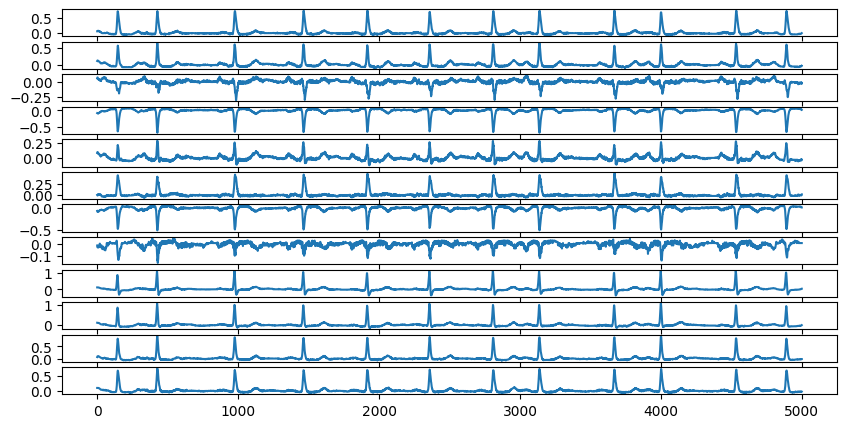

<Figure size 640x480 with 0 Axes>

encoder mask 0


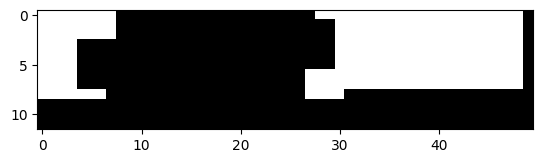

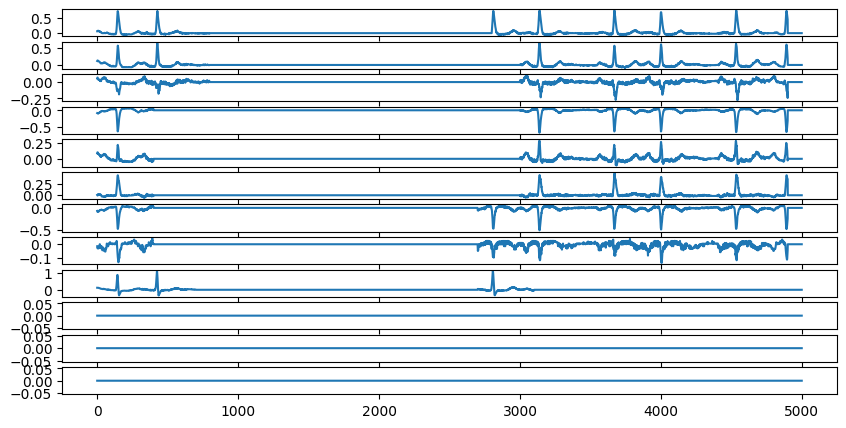

<Figure size 640x480 with 0 Axes>

predictor mask 0


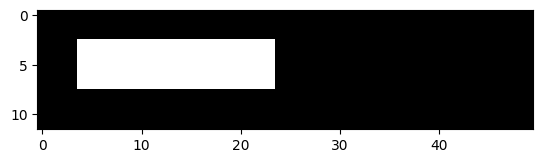

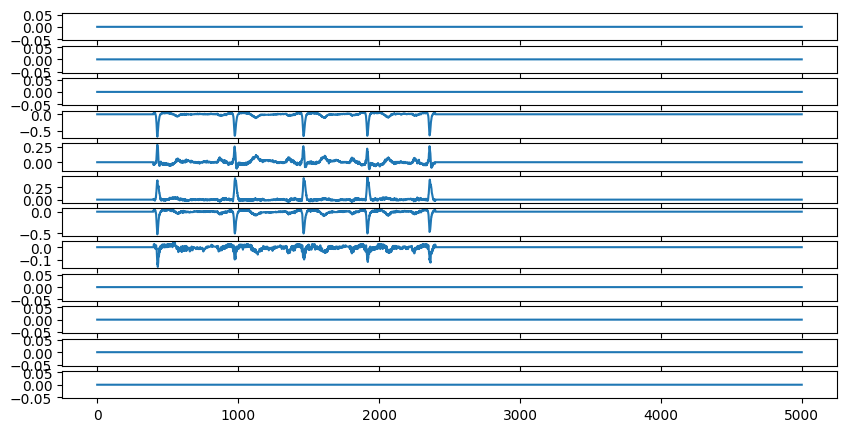

<Figure size 640x480 with 0 Axes>

predictor mask 1


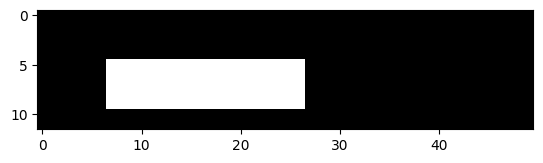

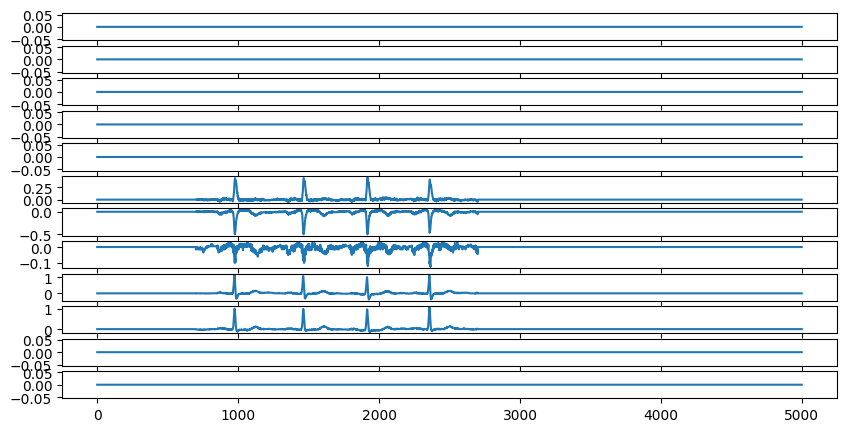

<Figure size 640x480 with 0 Axes>

predictor mask 2


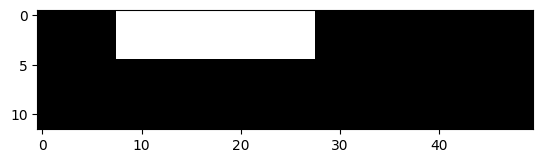

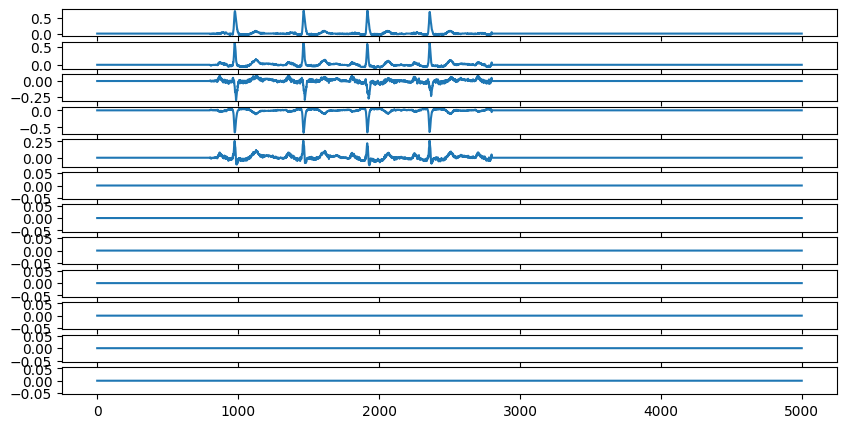

<Figure size 640x480 with 0 Axes>

predictor mask 3


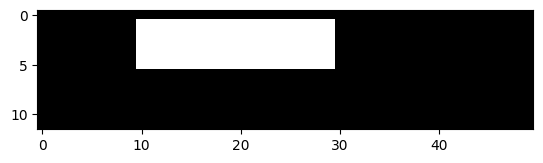

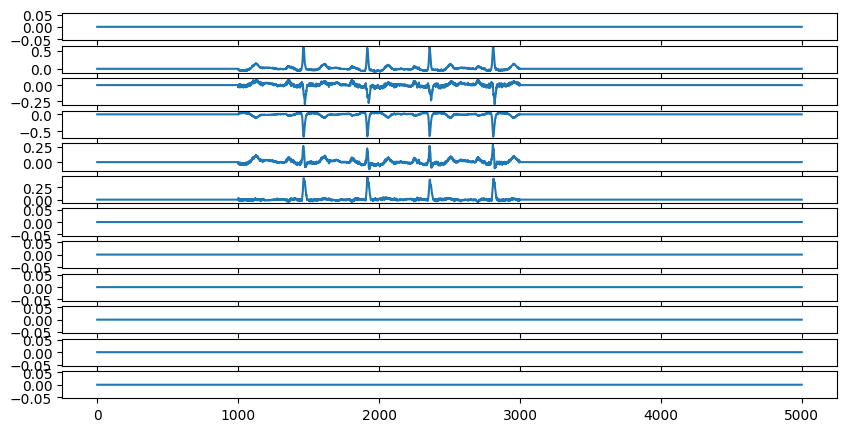

<Figure size 640x480 with 0 Axes>

In [14]:
itr, (udata, masks_enc, masks_pred) = next(iter)
signal, target = udata
signal = signal[0].squeeze()
signal.shape
plot_ecg(signal)

for i, x in enumerate(masks_enc):
    print(f'encoder mask {i}')
    mask_enc_full = torch.zeros(600)

    mask_enc_full[x[0]] = 1

    mask_enc_full = mask_enc_full.reshape(12,50)
    plt.imshow(mask_enc_full,cmap="grey")
    mask_enc_full = np.repeat(mask_enc_full,100,axis=1)

    plot_ecg(signal, mask_enc_full)
    

for i, x in enumerate(masks_pred):
    print(f'predictor mask {i}')

    mask_enc_full = torch.zeros(600)

    mask_enc_full[x[0]] = 1


    mask_enc_full = mask_enc_full.reshape(12,50)
    plt.imshow(mask_enc_full,cmap="grey")
    mask_enc_full = np.repeat(mask_enc_full,100,axis=1)

    plot_ecg(signal, mask_enc_full)